In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data/project03

/content/drive/MyDrive/data/project03


In [3]:
# 2번 실행해야 되는 경우가 있음

# 이미지 파일이랑 csv파일을 
LOCAL_FLICKR_PATH = 'flickr30k_images/'
annotation_file = LOCAL_FLICKR_PATH + 'results.csv'
LOCAL_IMG_PATH = LOCAL_FLICKR_PATH + 'flickr30k_images/'

# !ls {LOCAL_IMG_PATH} | wc

# # 결과 값 0 0 0이 아닌 31785   31785  468996 이 나와야 함

In [4]:
#Import Librarires
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [5]:
#Import resnet model for feature extraction
extract_model = ResNet50(include_top=True)
last = extract_model.layers[-2].output
image_features_extract_model = Model(inputs = extract_model.input,outputs = last)    

102981632/102967424 [==============================] - 0s 0us/step


In [6]:
# h5 모델 로드
#Import the CNN RNN model
                                  # 모델 위치 설정
reconstructed_model = load_model('model/model_ImageCap_Umair.h5')

In [7]:
# 피클화된 토큰 로드
#Import tokenizor from pickle file
          # 피클 경로 설정
with open('model/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [8]:
# 단어의 출력 길이 설정
#State vocab size, max length(max tokens)
vocab_size = len(tokenizer.word_index) 
max_tokens = 73
START_TOKEN = '<start> '
END_TOKEN = ' <end>'
token_start = tokenizer.word_index[START_TOKEN.strip()]
token_end = tokenizer.word_index[END_TOKEN.strip()]

In [20]:
# 테스트 이미지 파일 경로 설정
#Import the file, incase of an application the user will upload the file here
image_path = 'testimg/zoo.jpg'

In [26]:
# 이미지 파일을 캡셔닝하기 위한 전처리
#Presprocess the image
from tensorflow.keras.preprocessing import image
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
image = tf.keras.applications.resnet.preprocess_input(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['two young girls are sitting on the ground in front of building <end>']


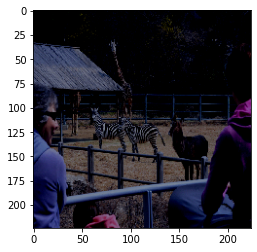

In [27]:
# 전처리 된 이미지 파일을 이용해 토큰(피클)에서 단어 조합
#Use the prediction coding,extarct image features from ResNet50 model and RNN features from ------>
#Reconstructed model, use that model to predict
encoder_input = image_features_extract_model.predict(image)
encoder_input = tf.reshape(encoder_input,
                             (2048, ))

encoder_input = np.expand_dims(encoder_input, axis=0)

shape = (1, max_tokens)
decoder_input = np.zeros(shape=shape, dtype=np.int)

token_id = token_start

output=[]

count_tokens = 0

while token_id != token_end and count_tokens < max_tokens:
    
    decoder_input[0, count_tokens] = token_id

    input_data ={'encoder_input':encoder_input ,'decoder_input': decoder_input}
    
    predict = reconstructed_model.predict(input_data)
    
    token_id = np.argmax(predict[0, count_tokens, :])
    
    output.append(token_id)
    
    count_tokens += 1

#Print prediction    
final = tokenizer.sequences_to_texts([output])
print(final)
#Print Image
plt.imshow(np.squeeze(x /255.))

In [28]:
tmp = final[0][:-5].split(' ')
tmp

['two',
 'young',
 'girls',
 'are',
 'sitting',
 'on',
 'the',
 'ground',
 'in',
 'front',
 'of',
 'building',
 '']

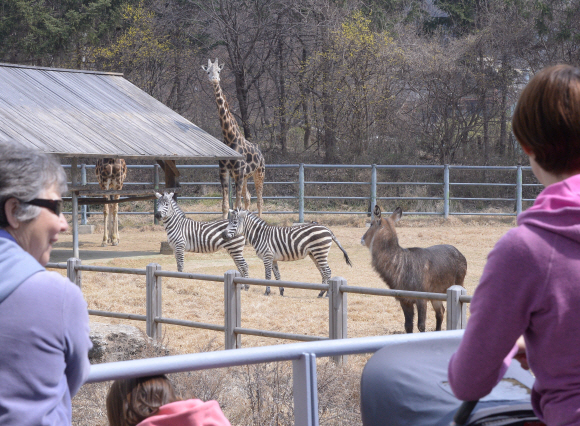

In [29]:
from PIL import Image

Image.open(image_path)

In [ ]:
# 캡셔닝을 굉장히 많이 훈련시키지 않으면 무의미 할 것 같음